# AutoEncoders (Autoencoder + Latent Space Visualization + Denoising)

__Notebook Author__: Hamed Qazanfari

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hamedmit/VisionLab/blob/main/FC_Autoencoder_Latent_Denoising.ipynb)
[![Open In kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/hamedmit/VisionLab/blob/main/FC_Autoencoder_Latent_Denoising.ipynb)

---

## Notebook Objectives

In this notebook, we implement a fully connected autoencoder to reconstruct images. An AutoEncoder has two networks, the encoder network which reduces the dimensionality of the data into its latent space representation, and the decoder network which increases the dimensionality and reconstructs the input from the latent space representation. The model is trained and analyzed in two ways:

1- Reconstruction and Latent Space Analysis

- The autoencoder is trained to reconstruct images.
- The latent space representations are visualized using PCA and t-SNE to analyze data distribution.
- We check whether the model can slightly reduce noise, even without explicit training for denoising.

2- Noise Addition and Denoising

- Different noises are added to the images.
- The model is trained with noisy inputs to learn denoising.
- We compare the quality of normal reconstruction versus denoised output.


In [2]:
# @title setup and imports

import numpy as np
from matplotlib import pyplot as plt
from tqdm import trange

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision import transforms, models
from torchvision.datasets.mnist import MNIST
from torchvision.datasets.cifar import CIFAR10

torch.manual_seed(0)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# @title plotting functions

def plot_history(history):
    if 'train_acc' in history:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(history['train_loss'], label='train')
        ax1.plot(history['test_loss'], label='test')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(history['train_acc'], label='train')
        ax2.plot(history['test_acc'], label='test')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
    else:
        plt.plot(history['train_loss'], label='train')
        plt.plot(history['test_loss'], label='test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    plt.show()


def visualize(embedded, labels, title=''):
    fig, ax = plt.subplots(figsize=(12,8))

    # get discrete colormap
    cmap = plt.get_cmap('jet', 10) # virdis

    # plot scatter points
    scatter = ax.scatter(embedded[:, 0], embedded[:, 1], c=labels, cmap=cmap)

    # add colorbar
    cbar = plt.colorbar(scatter)

    # set ticks locations
    cbar.set_ticks((np.arange(10) + 0.5) * (10 - 1) / 10)

    # set tick labels
    cbar.set_ticklabels([str(i) for i in range(10)])

    plt.title(title)
    plt.show()


def plot_last_hidden_layer(model, dataloader, method='PCA'):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.last_hidden_layer(imgs.to(device))
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Last Hidden Layer using t-SNE'

    visualize(embedded, labels, title)


def plot_autoencoder(model, dataloader, method='PCA', denoising=False):
    with torch.no_grad():
        encoded_data, labels = [], []
        for imgs, lbls in dataloader:
            encoded = model.encoder(imgs.to(device))
            if denoising:
                encoded = encoded.view(encoded.size(0), -1)
            encoded_data.append(encoded.cpu().numpy())
            labels.append(lbls.cpu().numpy())

    # Concatenate the encoded representations and labels
    encoded_data = np.concatenate(encoded_data, axis=0)
    labels = np.concatenate(labels, axis=0)

    if encoded_data.shape[1] == 2:
        embedded = encoded_data
        title = 'Latent Space'
    elif method == 'PCA':
        embedded = PCA(n_components=2).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using PCA'
    else:
        embedded = TSNE(n_components=2, learning_rate='auto', init='random',
                        perplexity=3).fit_transform(encoded_data)
        title = 'Reduction of the Latent Space using t-SNE'

    visualize(embedded, labels, title)



def plot_reconstruction(model, dataset, denoising=False, mask=False):
    # Choose 10 random samples
    random_indices = np.random.choice(len(dataset), size=10, replace=False)

    # Get images and labels for the chosen samples
    images = [dataset[i][0] for i in random_indices]
    labels = [dataset[i][1] for i in random_indices]

    is_grayscale = images[0].shape[0]==1
    cmap = 'gray' if is_grayscale else None

    if denoising:
        noisy_images = [add_noise(image, mask=mask) for image in images]

    # Reconstruct the images using the autoencoder
    with torch.no_grad():
        if denoising:
            reconstructed_images = [model(noisy_image.unsqueeze(0).to(device)).squeeze().cpu() for noisy_image in noisy_images]
        else:
            reconstructed_images = [model(image.unsqueeze(0).to(device)).squeeze().cpu() for image in images]

    if denoising:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(3, 10, figsize=(15, 5))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Original {classes[labels[i]]}")
            axes[0, i].axis('off')

        # Second row: Noisy images
        for i, image in enumerate(noisy_images):
            if is_grayscale:
                axes[1, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:

                axes[1, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[1, i].set_title(f"Noisy {classes[labels[i]]}")
            axes[1, i].axis('off')

        # Third row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[2, i].imshow(image.squeeze().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[2, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[2, i].set_title(f"Reconstructed")
            axes[2, i].axis('off')

    else:
        # Display the original and reconstructed images
        fig, axes = plt.subplots(2, 10, figsize=(15, 3))

        # First row: Original images
        for i, image in enumerate(images):
            if is_grayscale:
                axes[0, i].imshow(image.squeeze().numpy(), cmap=cmap)
            else:
                axes[0, i].imshow(image.permute(1,2,0).numpy(), cmap=cmap)
            axes[0, i].set_title(f"Label: {classes[labels[i]]}")
            axes[0, i].axis('off')

        # Second row: Reconstructed images
        for i, image in enumerate(reconstructed_images):
            if is_grayscale:
                axes[1, i].imshow(image.detach().numpy().reshape(28, 28), cmap=cmap)
            else:
                axes[1, i].imshow(image.detach().numpy(), cmap=cmap)
            axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# @title MNIST dataset

batch_size = 256

trainset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # The Encoder Network
        self.encoder = nn.Sequential(nn.Flatten(),
                                     nn.Linear(28 * 28, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 16),)
        # The Decoder Network
        self.decoder = nn.Sequential(nn.Linear(16, 64),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(64, 256),
                                     nn.ReLU(inplace=True),
                                     nn.Linear(256, 28 * 28),
                                     nn.Unflatten(1, (1, 28, 28)),
                                     nn.Sigmoid())

    def forward(self, x):
        out = self.decoder(self.encoder(x))
        return out

In [6]:
# @title AutoEncoder helper functions
def mask_image(x, square_size=5, number_of_squares=3):
    masked = x.clone()
    for _ in range(number_of_squares):
        start_i = torch.randint(0, x.shape[-2]-square_size, (1, ))
        start_j = torch.randint(0, x.shape[-1]-square_size, (1, ))
        masked[..., start_i:start_i+square_size, start_j:start_j+square_size]=0
    return masked

def add_noise(x, mask= False):
    if mask:
        return mask_image(x)

    select_mode = np.random.uniform()

    if select_mode <= 1/6: # gaussian noise
        noisy = x + torch.randn_like(x) * 0.5

    elif select_mode <= 2/6: # salt and pepper noise
        noise = torch.rand_like(x)
        noisy = x.clone()
        noisy[noise < 0.1] = 0
        noisy[noise > 0.9] = 1

    elif select_mode <= 3/6: # speckle noise
        noisy = x + x*torch.randn_like(x)

    elif select_mode <= 4/6: # poisson
        noisy = torch.poisson(x * 2)/2

    elif select_mode <= 5/6: # square masking
        noisy = mask_image(x, square_size=4, number_of_squares=4)

    else: # bluring
        noisy = transforms.GaussianBlur(5, sigma=(2,2))(x)

    noisy[noisy < 0] = 0
    noisy[noisy > 1] = 1
    return noisy

def autoencoder_train_step(model, dataloader, loss_fn, optimizer, denoising, mask, device):
    model.train()
    train_loss = 0.
    for images, _ in dataloader:
        images = images.to(device)
        if denoising: # Add noise to the images
            noisy_images = add_noise(images, mask= mask)
            recons = model(noisy_images)
        else:
            recons = model(images)
        loss = loss_fn(recons, images)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    train_loss /= len(dataloader)
    return train_loss


def autoencoder_test_step(model, dataloader, loss_fn, denoising, mask, device):
    model.eval()
    test_loss = 0.
    with torch.inference_mode():
        for images, _ in dataloader:
            images = images.to(device)
            if denoising: # Add noise to the images
                noisy_images = add_noise(images, mask=mask)
                recons = model(noisy_images)
            else:
                recons = model(images)
            loss = loss_fn(recons, images)
            test_loss += loss.item()
        test_loss /= len(dataloader)
    return test_loss


def train_autoencoder(model, train_dataloader, test_dataloader, n_epochs, denoising=False, mask=False, device=device):
    history = {'train_loss': [], 'test_loss': []}
    optimizer = Adam(model.parameters())
    loss_fn = nn.MSELoss()
    for _ in (pbar := trange(n_epochs)):
        train_loss = autoencoder_train_step(model, train_dataloader, loss_fn, optimizer, denoising, mask, device)
        history['train_loss'].append(train_loss)
        test_loss = autoencoder_test_step(model, test_dataloader, loss_fn, denoising, mask, device)
        history['test_loss'].append(test_loss)
        pbar.set_description(f'Training Loss {train_loss:.3f} | Test Loss {test_loss:.3f} ')
    return history


Using the Mean Squared Error loss we can train the AutoEncoder to reconstruct images after encoding them using the encoder network and decoding the encoded representation.

Training Loss 0.010 | Test Loss 0.010 : 100%|██████████| 30/30 [07:44<00:00, 15.50s/it]


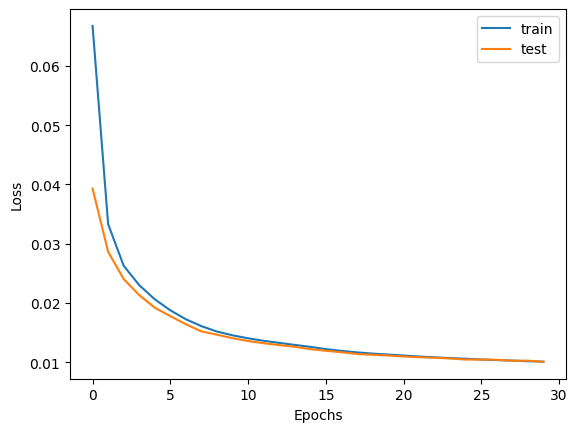

In [7]:
autoencoder = AutoEncoder().to(device)

res = train_autoencoder(autoencoder, trainloader, testloader, n_epochs=30)
plot_history(res)

We can reconstruct images from the training dataset:

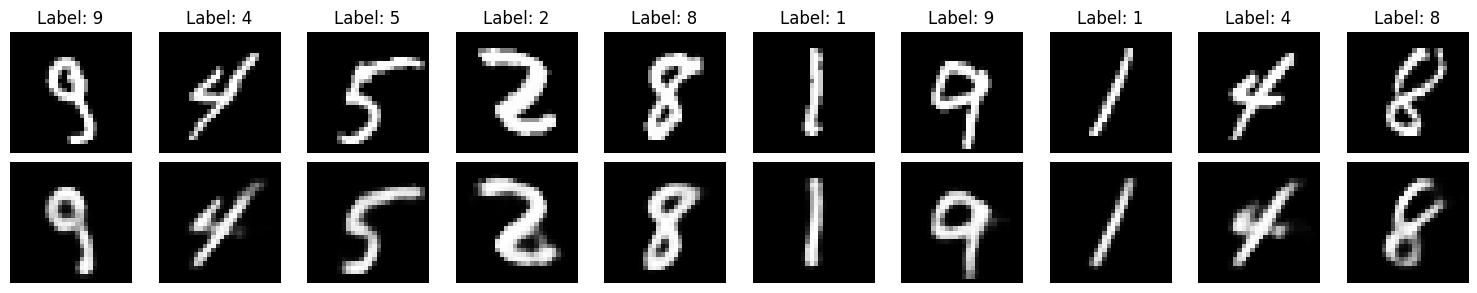

In [8]:
plot_reconstruction(autoencoder, trainset)

Or we can reconstruct images from the test dataset:

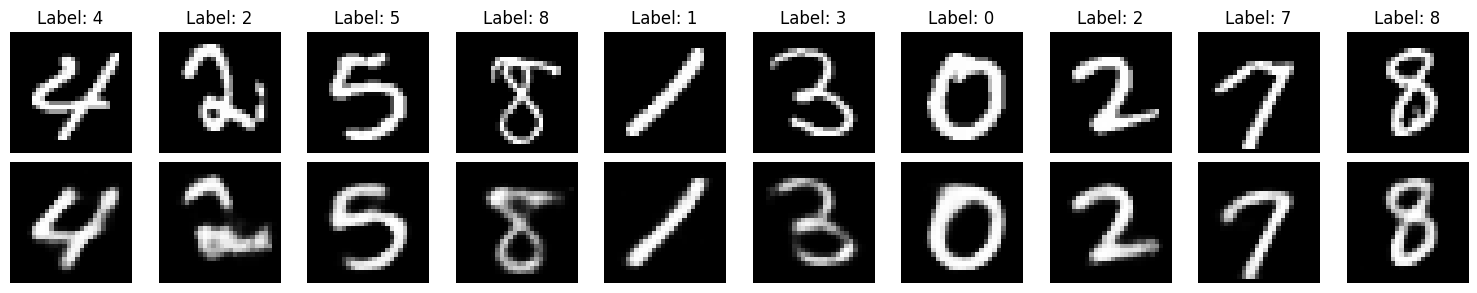

In [9]:
plot_reconstruction(autoencoder, testset)

## Latent Space Analysis Section

While it would have been possible to encode the inputs into a two dimensional latent space, the reconstruction loss would not have been so easy to reduce. Therefore we can use PCA to reduce the latent space dimensions to two for visualization purposes.

Here, we extract and visualize the latent space features using PCA and t-SNE to understand how the autoencoder encodes information in a lower-dimensional space.

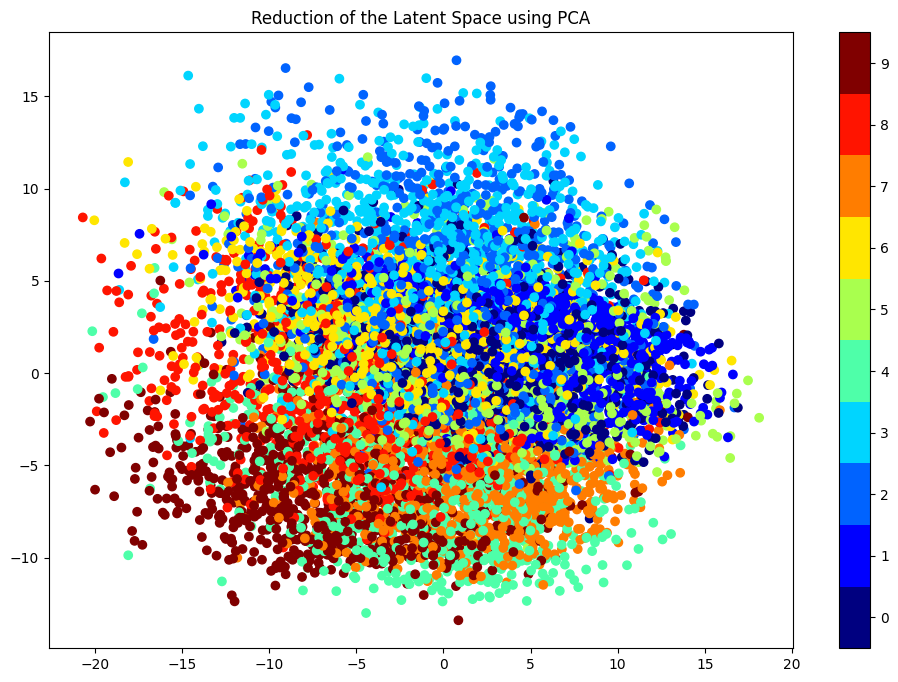

In [10]:
plot_autoencoder(autoencoder, testloader, method='PCA')

We can also use t-SNE:

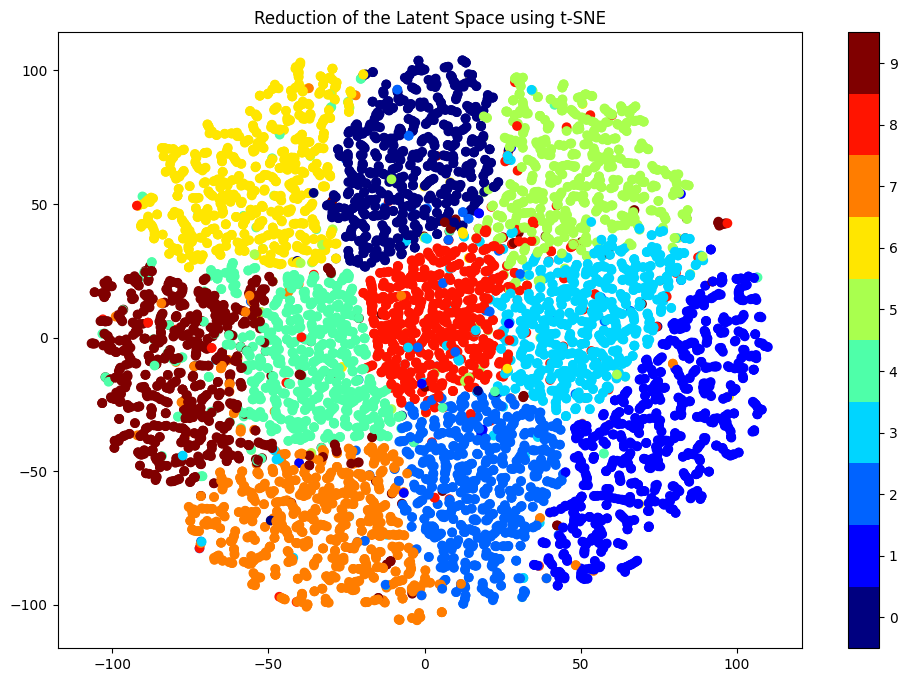

In [11]:
plot_autoencoder(autoencoder, testloader, method='t-SNE')

## Denoising

Another application of AutoEncoders is denoising. Even without training the AutoEncoder to denoise the inputs, we can see decent results.

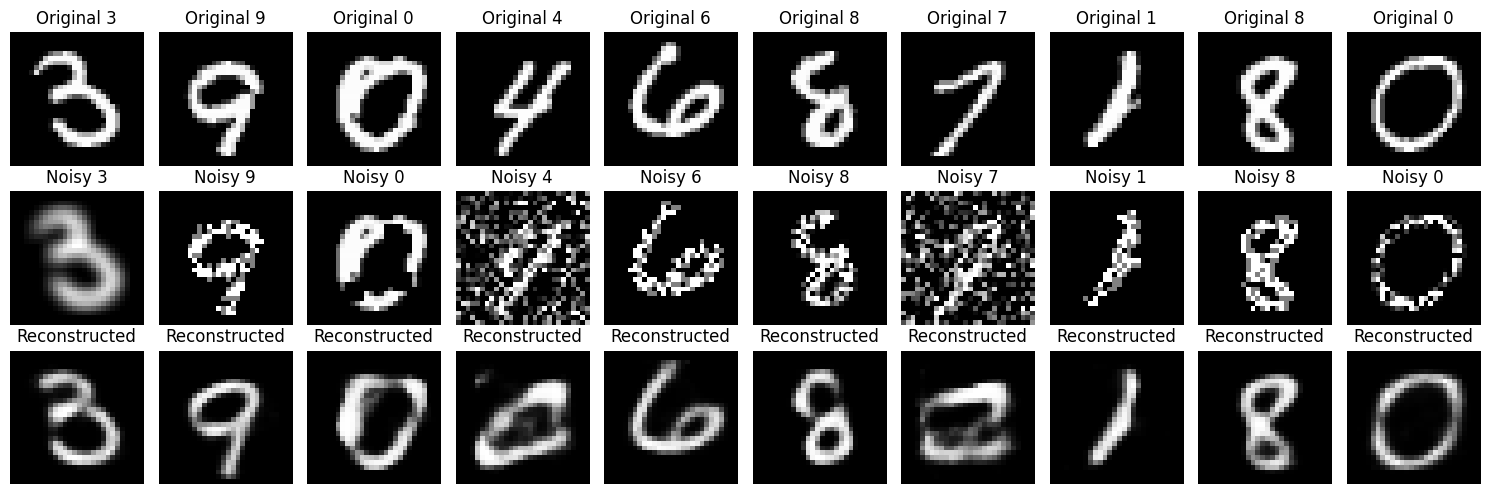

In [12]:
plot_reconstruction(autoencoder, testset, denoising=True)

# Denoising AutoEncoder

To make the model further robust to noises we can train an AutoEncoder with noisy data as input and the original data as desired output to obtain a model that removes the noise from data! These type of AutoEncoders are called Denoising AutoEncoders.

Training Loss 0.018 | Test Loss 0.017 : 100%|██████████| 30/30 [07:04<00:00, 14.15s/it]


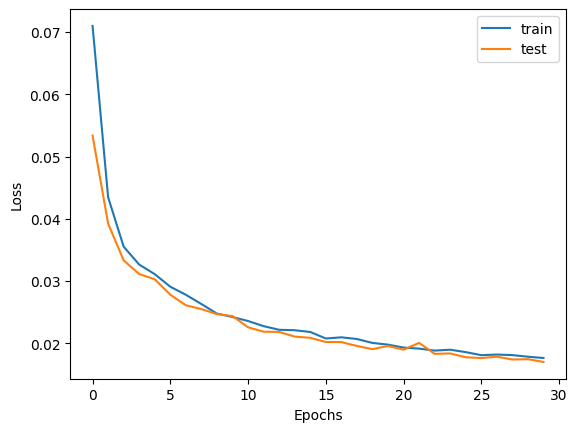

In [13]:
dae = AutoEncoder().to(device)

res = train_autoencoder(dae, trainloader, testloader, n_epochs=30, denoising=True)
plot_history(res)

We can compare the output of the denoising autoencoder to the normal autoencoder and see how much it has improved!

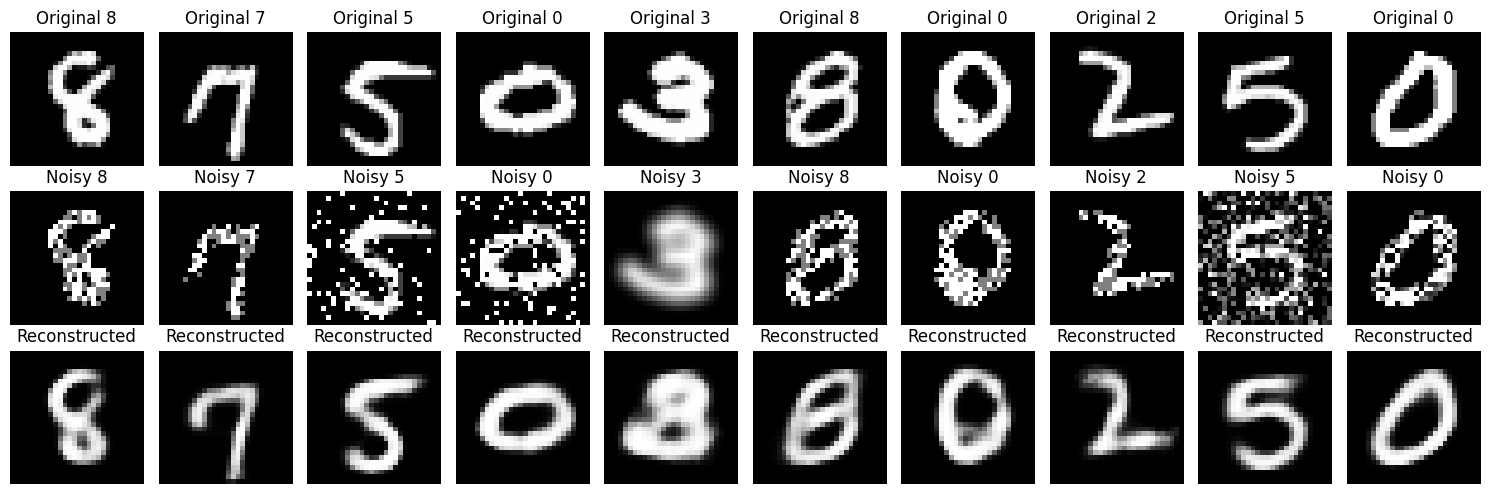

In [14]:
plot_reconstruction(dae, testset, denoising=True)

## Conclusion:

This model not only reconstructs images but also shows some level of noise reduction. The latent space analysis indicates that dimensionality reduction can help differentiate between different classes. However, for optimal denoising, a CNN-based autoencoder is likely to perform better.